In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import numpy as np
from adabmDCA.functional import one_hot
from collections import Counter, OrderedDict

import sys
sys.path.append('..')
import utils

# %config Completer.use_jedi = True

In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = range(len(round_ids))

In [3]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/scrotti/Aptamer2025py/experiments/../utils.py'>

In [4]:
def seq_to_counts(sequences):
    seq_unique, counts = sequences.unique(dim=0, return_counts=True)
    perm = counts.argsort(descending=True)
    return seq_unique[perm], counts[perm]

def array_to_string(sequences):
    tokens = np.array(['A', 'C', 'G', 'U'])
    return np.apply_along_axis(''.join, 1, tokens[sequences])

def hamming(x, y):
    return (x != y).sum(dim=-1)

In [7]:
seq_nonunique = [utils.sequences_from_files(experiment_ids[n], round_ids) for n in ns]

Extracting sequences...
Finished round ARN
Finished round R01
Finished round R02N
Extracting sequences...
Finished round ARN
Finished round R01
Finished round R02N
Extracting sequences...
Finished round ARN
Finished round R01
Finished round R02N


In [8]:
seq_round_zero_nonunique = [s[0] for s in seq_nonunique]

In [9]:
# seq_round_zero_nonunique = [utils.sequences_from_file(experiment_ids[n], "ARN") for n in ns]

In [46]:
seq_counts = [[seq_to_counts(s_exp_round) for s_exp_round in s_exp] for s_exp in seq_nonunique]

In [48]:
seq_counts_round_zero = [s[0] for s in seq_counts]

In [49]:
# seq_counts_round_zero = [seq_to_counts(seq) for seq in seq_round_zero_nonunique]

In [50]:
def most_abundant(seq_counts, n=5):
    sequences, counts = seq_counts
    sequences = sequences[:n]
    counts = counts[:n]
    seq_str = array_to_string(sequences)
    df = pd.DataFrame(zip(seq_str, counts.numpy()), columns=['Sequence', 'Count'])
    return df

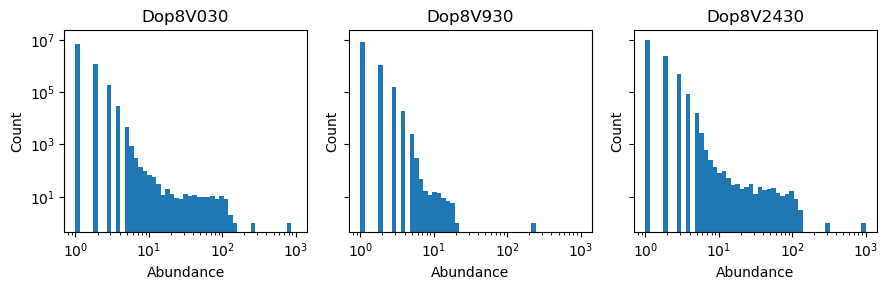

In [95]:
fig, axes = plt.subplots(1,3, figsize=(9,3), sharey=True)
for n in ns:
    seq_counts_ = seq_counts_round_zero[n]
    sequences, counts = seq_counts_
    ax = axes[n]
    ax.hist(counts, bins=torch.logspace(0, 3, 50))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Abundance')
    ax.set_ylabel('Count')
    ax.set_title(experiment_ids[n])
plt.tight_layout()

## Most abundant sequences

In [52]:
for n in ns:
    seq_counts_ = seq_counts_round_zero[n]
    print(experiment_ids[n])
    print(most_abundant(seq_counts_))
    print()

Dop8V030
                                        Sequence  Count
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1674
1  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA    795
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    253
3  AUGGAACUCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    152
4  AUGGAACCCCGACAUCUACGUGCGGUGUACAGACAUCUGAUGUCG    133

Dop8V930
                                        Sequence  Count
0  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG    232
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCAGCAGCCG     22
2  GACAUCAUACAUGUCGAACAGCUUUCUAACGGAGCCCCGCAGCCG     19
3  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGACCCGCAGCCG     18
4  GACAUCAUACAUGUCGAACAGCUUUCCAAUGGAGCCCCGCAGCCG     18

Dop8V2430
                                        Sequence  Count
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1742
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG   1209
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA   1000
3  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    292
4  AUGGAACCCCGACAU

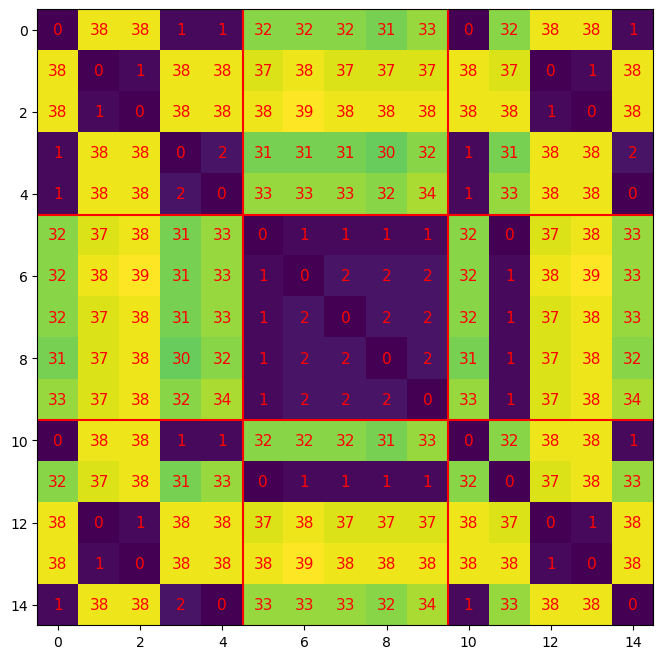

In [53]:
M = 5
mat = torch.zeros(3, M, 3, M, dtype=int)
for m in ns:
    for i in range(M):
        for n in ns:
            for j in range(M):
                d = hamming(seq_counts_round_zero[m][0][i], seq_counts_round_zero[n][0][j])
                mat[m,i,n,j] = d
                
mat_resh = mat.reshape(3*M,3*M)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(mat_resh, origin='upper')
for i in range(1, len(ns)):
    ax.axvline(x=i*M-0.5, color="red")
    ax.axhline(y=i*M-0.5, color="red")

for i in range(3*M):
    for j in range(3*M):
        text = ax.text(j, i, mat_resh[i, j].item(),
                       ha="center", va="center", color="r", fontsize=11)

fig.savefig('3dataset_distances.png')

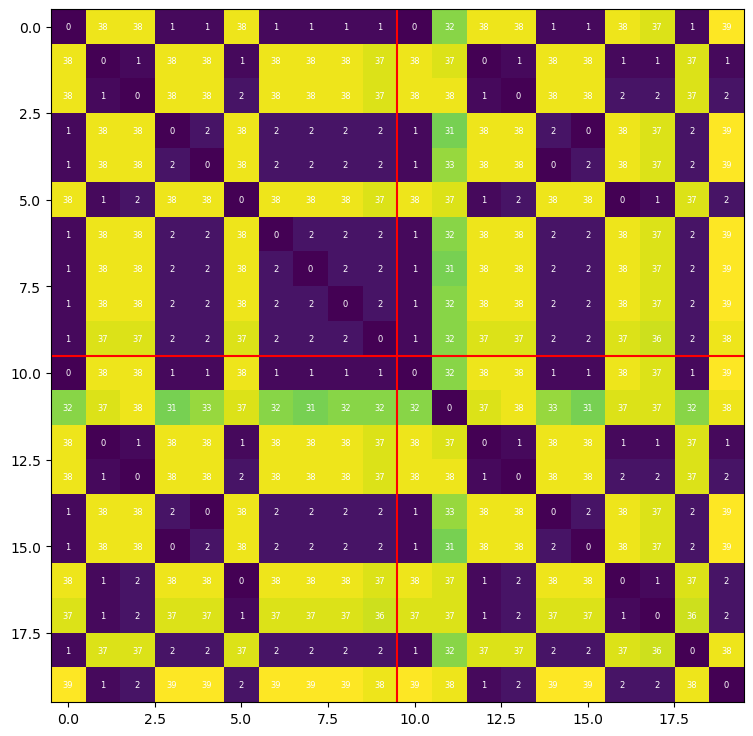

In [54]:
M = 10
mat = torch.zeros(2, M, 2, M, dtype=int)
ns_ = [0,2]
for m in range(2):
    for i in range(M):
        for n in range(2):
            for j in range(M):
                d = hamming(seq_counts_round_zero[ns_[m]][0][i], seq_counts_round_zero[ns_[n]][0][j])
                mat[m,i,n,j] = d
                
mat_resh = mat.reshape(2*M,2*M)
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(mat_resh, origin='upper')
for i in range(1, len(ns_)):
    ax.axvline(x=i*M-0.5, color="red")
    ax.axhline(y=i*M-0.5, color="red")

for i in range(2*M):
    for j in range(2*M):
        text = ax.text(j, i, mat_resh[i, j].item(),
                       ha="center", va="center", color="w", fontsize=6)

## Wildtypes

### Guess wildtype from counts

In [55]:
wt_counts = [seq_counts_round_zero[n][0][0] for n in ns]

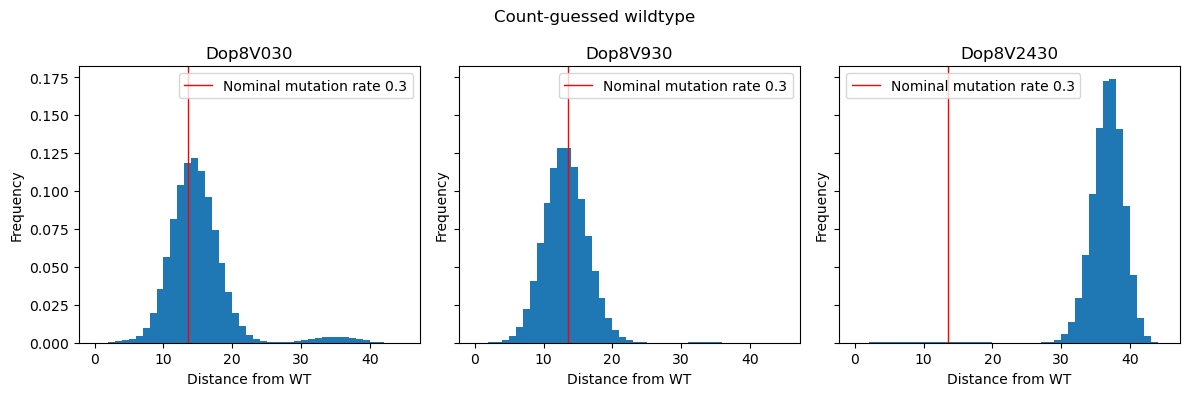

In [56]:
distances_counts = [hamming(wt_counts[n], seq_counts_round_zero[n][0]) for n in ns]

fig, axes = plt.subplots(1,3, figsize=(12, 4), 
                        sharex=True, sharey=True
                        )
for n in ns:
    ax = axes[n]
    N, bins, patches = ax.hist(distances_counts[n], bins=range(46), density=True, 
            # weights=seq_counts_round_zero[n][1]
           )
    ax.axvline(x=0.3*45, color="red", linewidth=1, label='Nominal mutation rate 0.3')
    ax.legend()
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')
    ax.set_ylabel('Frequency')
fig.suptitle('Count-guessed wildtype')
fig.tight_layout()

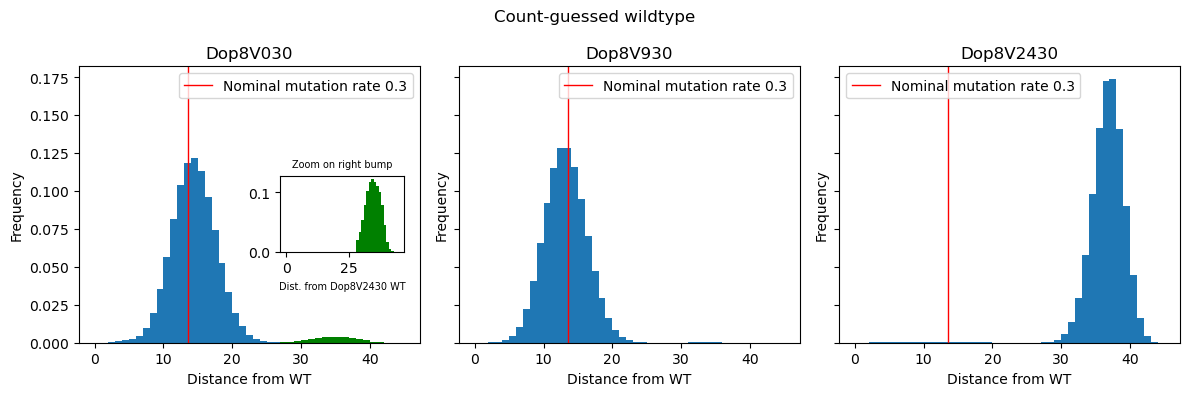

In [57]:
thresh = 27

fig, axes = plt.subplots(1,3, figsize=(12, 4), 
                        sharex=True, sharey=True
                        )
for n in ns:
    ax = axes[n]
    N, bins, patches = ax.hist(distances_counts[n], bins=range(46), density=True, 
            # weights=seq_counts_round_zero[n][1]
           )
    ax.axvline(x=0.3*45, color="red", linewidth=1, label='Nominal mutation rate 0.3')
    ax.legend()
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')
    ax.set_ylabel('Frequency')

    if n == 0:
        for i in range(thresh, 45):
            patches[i].set_facecolor('g')
        axin = ax.inset_axes((27, 0.06, 18, 0.05), transform=ax.transData)
        idx = distances_counts[n] > thresh
        distances_cross = hamming(wt_counts[2-n], seq_counts_round_zero[n][0][idx])
        axin.hist(distances_cross, density=True, bins=range(46), color='g')
        axin.set_title('Zoom on right bump', fontsize=7)
        axin.set_xlabel(f'Dist. from {experiment_ids[2-n]} WT', fontsize=7)
        
fig.suptitle('Count-guessed wildtype')
fig.tight_layout()

### Guess wildtype from single-site frequencies

In [58]:
def guess_wt_sites(seq_counts):
    seq, counts = seq_counts
    seq_oh = one_hot(seq)
    seq_oh_weighted = seq_oh * counts[:,None,None]
    fi = seq_oh_weighted.mean(dim=0)
    wt = fi.argmax(dim=1)
    return wt

In [59]:
wt_sites = [guess_wt_sites(seq_counts_round_zero[n]) for n in ns]

In [60]:
for n in ns:
    yn = wt_sites[n] in seq_counts_round_zero[n][0]
    yn_str = ' '
    if not yn:
        yn_str = ' not '
    print(f'The WT guessed from site counts for dataset {experiment_ids[n]} is{yn_str}present in the dataset')

The WT guessed from site counts for dataset Dop8V030 is present in the dataset
The WT guessed from site counts for dataset Dop8V930 is present in the dataset
The WT guessed from site counts for dataset Dop8V2430 is present in the dataset


In [61]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:60% !important; }</style>"))

def most_abundant_with_distance(seq_counts, wt_count, wt_site, n=5):
    sequences, counts = seq_counts
    sequences = sequences[:n]
    counts = counts[:n]
    seq_str = array_to_string(sequences)
    dist_count = hamming(wt_count, sequences).numpy()
    dist_site = hamming(wt_site, sequences).numpy()
    df = pd.DataFrame(zip(seq_str, counts.numpy(), dist_count, dist_site), 
                      columns=['Sequence', 'Count', 'Distance from count WT', 'Distance from consensus WT'])
    return df

for n in ns:
    seq_counts_ = seq_counts_round_zero[n]
    print(experiment_ids[n])
    print(most_abundant_with_distance(seq_counts_, wt_counts[n], wt_sites[n], 6).to_string(index=False))
    print()

Dop8V030
                                     Sequence  Count  Distance from count WT  Distance from consensus WT
AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1674                       0                           0
CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA    795                      38                          38
CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    253                      38                          38
AUGGAACUCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    152                       1                           1
AUGGAACCCCGACAUCUACGUGCGGUGUACAGACAUCUGAUGUCG    133                       1                           1
CGAGAUGAGAUGUCGGCCCACAGAUAACGGUCGAGGACCAUGCCA    129                      38                          38

Dop8V930
                                     Sequence  Count  Distance from count WT  Distance from consensus WT
GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG    232                       0                           0
GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCC

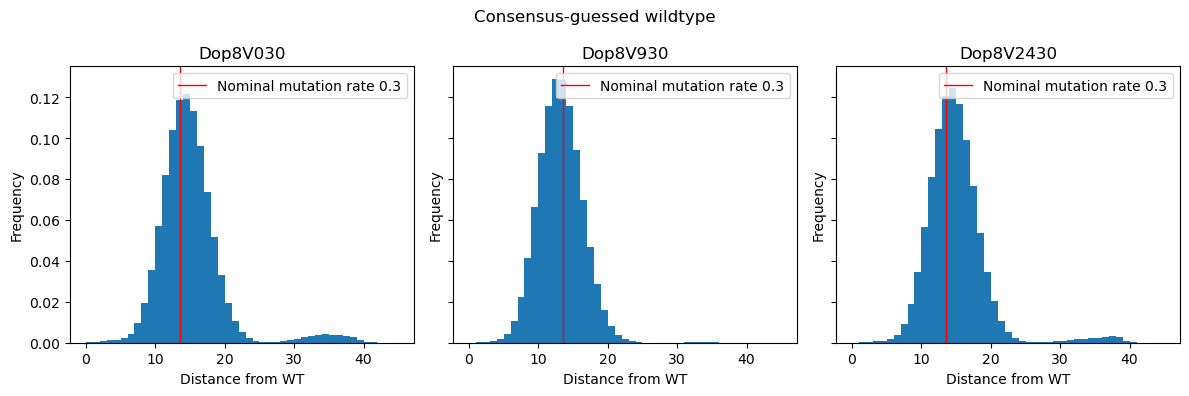

In [62]:
distances_sites = [hamming(wt_sites[n], seq_counts_round_zero[n][0]) for n in ns]

fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
for n in ns: 
    ax = axes[n]
    N, bins, patches = ax.hist(distances_sites[n], bins=range(46), density=True, 
            weights=seq_counts_round_zero[n][1]
           )
    ax.axvline(x=0.3*45, color="red", linewidth=1, label='Nominal mutation rate 0.3')
    ax.legend()
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')
    ax.set_ylabel('Frequency')
fig.suptitle('Consensus-guessed wildtype')
fig.tight_layout()

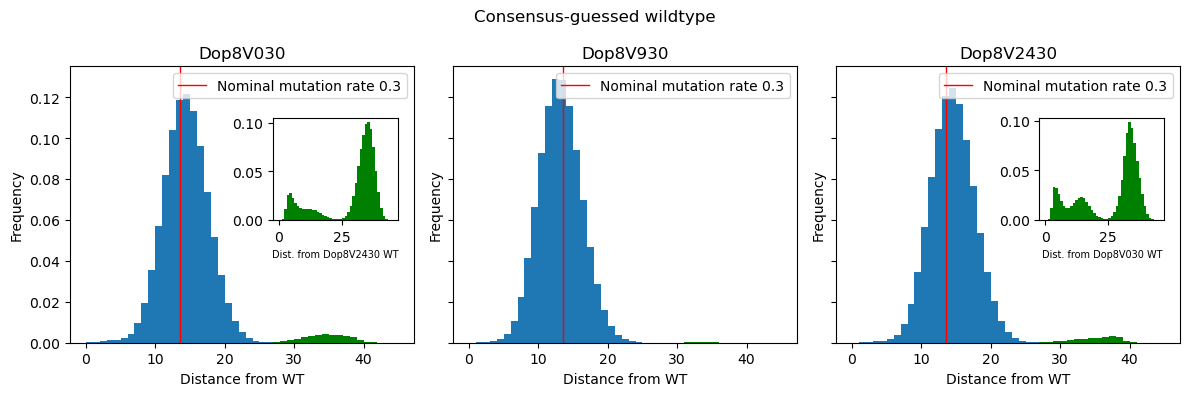

In [63]:
thresh = 27

fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
for n in ns: 
    ax = axes[n]
    N, bins, patches = ax.hist(distances_sites[n], bins=range(46), density=True, 
            weights=seq_counts_round_zero[n][1]
           )
    for i in range(thresh, 45):
        patches[i].set_facecolor('g')
    ax.axvline(x=0.3*45, color="red", linewidth=1, label='Nominal mutation rate 0.3')
    ax.legend()
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')
    ax.set_ylabel('Frequency')

    if n in [0,2]:
        axin = ax.inset_axes((27, 0.06, 18, 0.05), transform=ax.transData)
        idx = distances_sites[n] > thresh
        distances_cross = hamming(wt_sites[2-n], seq_counts_round_zero[n][0][idx])
        axin.hist(distances_cross, density=True, bins=range(46), color='g')
        # axin.set_title('Zoom on right bump', fontsize=7)
        axin.set_xlabel(f'Dist. from {experiment_ids[2-n]} WT', fontsize=7)
fig.suptitle('Consensus-guessed wildtype')
fig.tight_layout()

In [64]:
# fig, axes = plt.subplots(3,3, figsize=(6,6), sharex=True, sharey=True)
# for m in ns:
#     for n in ns:
#         if m != n:
#             ax = axes[m,n]
#             d = hamming(wt_sites[n], seq_counts_round_zero[m][0])
#             ax.hist(d, bins=range(46), density=True)
#             ax.set_xlabel(f'Distance from WT {experiment_ids[n]}', fontsize=8)
#             ax.set_title(f'Sequences from {experiment_ids[m]}', fontsize=8)
# plt.tight_layout()

In [65]:
for n in ns:
    seq_counts_ = seq_counts_round_zero[n]
    print(experiment_ids[n])
    print(most_abundant_with_distance(seq_counts_, wt_sites[n], 10))
    print()

Dop8V030
                                        Sequence  Count  \
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1674   
1  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA    795   
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    253   
3  AUGGAACUCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    152   
4  AUGGAACCCCGACAUCUACGUGCGGUGUACAGACAUCUGAUGUCG    133   

   Distance from count WT  Distance from consensus WT  
0                       0                          45  
1                      38                          45  
2                      38                          45  
3                       1                          45  
4                       1                          45  

Dop8V930
                                        Sequence  Count  \
0  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG    232   
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCAGCAGCCG     22   
2  GACAUCAUACAUGUCGAACAGCUUUCUAACGGAGCCCCGCAGCCG     19   
3  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGACCCGCAGCCG     1

## Hamming distances throughout rounds

In [66]:
ts = range(len(round_ids))

In [88]:
distances_counts = [[hamming(wt_sites[n], seq_counts[n][t][0]) for t in ts] for n in ns]

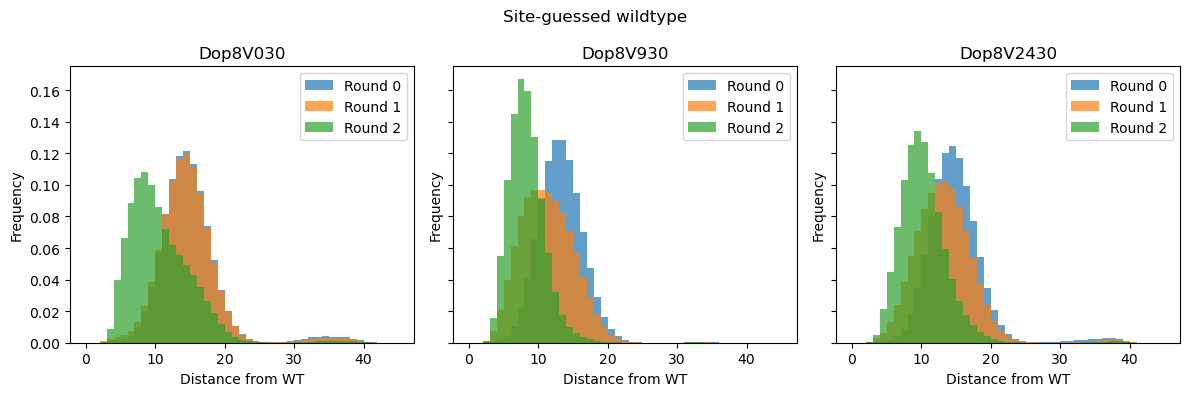

In [89]:
fig, axes = plt.subplots(1,3, figsize=(12, 4), 
                        sharex=True, sharey=True
                        )
for n in ns:
    ax = axes[n]
    for t in ts:
        N, bins, patches = ax.hist(distances_counts[n][t], bins=range(46), density=True,
                                  label=f'Round {t}', alpha=0.7)
    ax.legend()
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')
    ax.set_ylabel('Frequency')
fig.suptitle('Site-guessed wildtype')
fig.tight_layout()

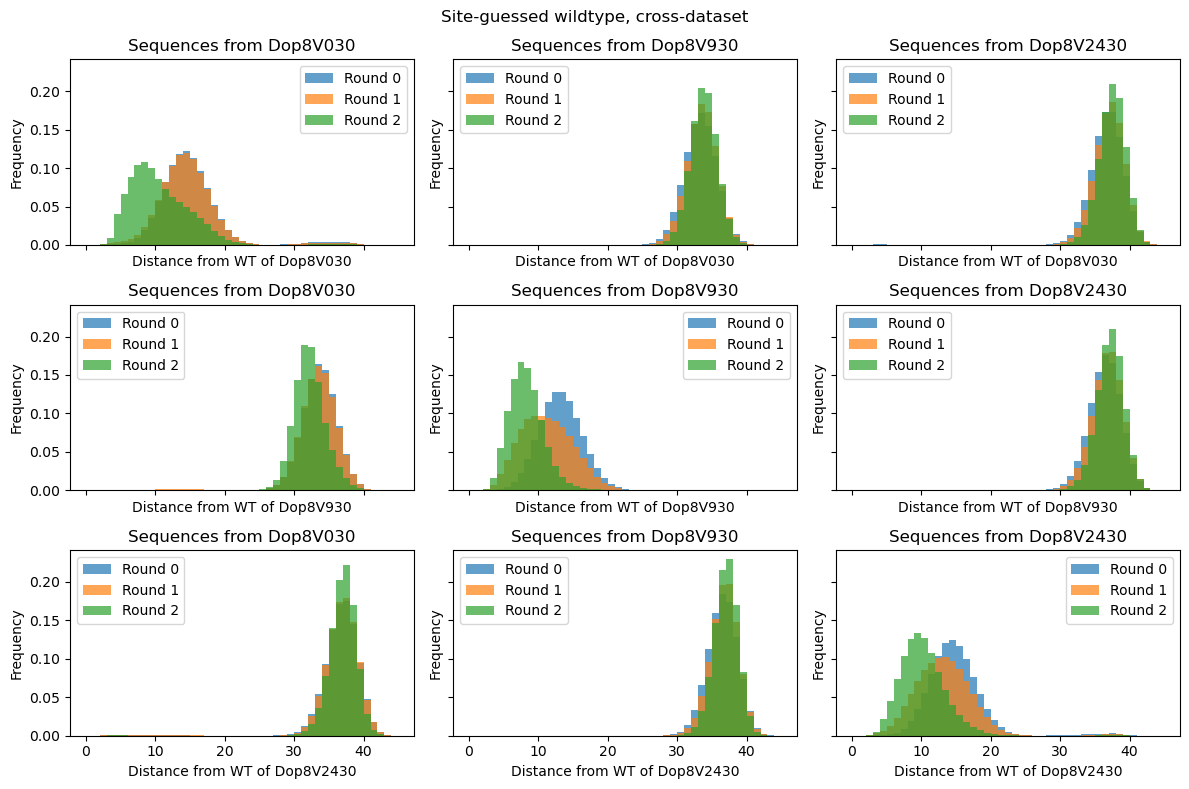

In [91]:
fig, axes = plt.subplots(3,3, figsize=(12, 8), 
                        sharex=True, sharey=True
                        )
for n in ns:
    for m in ns:
        ax = axes[m, n]
        for t in ts:
            X = hamming(wt_sites[m], seq_counts[n][t][0])
            N, bins, patches = ax.hist(X, bins=range(46), density=True,
                                      label=f'Round {t}', alpha=0.7)
        ax.legend()
        ax.set_title('Sequences from ' + experiment_ids[n])
        ax.set_xlabel('Distance from WT of ' + experiment_ids[m])
        ax.set_ylabel('Frequency')
fig.suptitle('Site-guessed wildtype, cross-dataset')
fig.tight_layout()